In [144]:
using StatsBase, LinearAlgebra
using StatsKit, Plots,ProgressMeter

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1242


In [2]:
teste1=[0 1 1 0 ;1 0 1 0 ;1 1 0 1 ;0 0 1 0]

4×4 Array{Int64,2}:
 0  1  1  0
 1  0  1  0
 1  1  0  1
 0  0  1  0

In [3]:
function D(net)
    ans = zeros(length(net[:,1]))
    aux = countmap(sum(net,dims=2)[:])
    for i = 1:length(net[:,1])
        try
            ans[i] = aux[i-1]
            catch
            ans[i] = 0
        end   
    end
    return ans
end

D (generic function with 1 method)

In [4]:
D(teste1)

4-element Array{Float64,1}:
 0.0
 1.0
 2.0
 1.0

In [5]:
function EP(net)
    pairs = zeros(length(net[:,1]))
    l = length(net[:,1])
    for node1=1:l
        for node2=node1+1:l
            if net[node1,node2]>0
                v = sum((net[node1,:].+net[node2,:]).==2)
                pairs[v+1]+=1
            end
        end
    end
    
    return pairs
end

EP (generic function with 1 method)

In [92]:
EP(teste1)
EP(ones(5,5)-)

BoundsError: BoundsError: attempt to access 5-element Array{Float64,1} at index [6]

In [7]:
function NE(net)
    return 0.5*((0:length(net[:,1])-1)'*D(net))
end

NE (generic function with 1 method)

In [8]:
NE(teste1)

4.0

In [9]:
function GWD(net,tau)
    gwdaux(i,tau,di) = (1-(1-exp(-tau))^i)*di
    di = D(net)[2:end-1]
    i=1:length(net[:,1])-2
    return exp(tau)*sum(gwdaux.(i,tau,di))
end

GWD (generic function with 1 method)

In [10]:
GWD(teste1,0.25)

3.44239843385719

In [11]:
function GWESP(net,tau)
    gwdaux(i,tau,di) = (1-(1-exp(-tau))^i)*di
    di = EP(net)[2:end-2]
    i=1:length(di)
    return exp(tau)*sum(gwdaux.(i,tau,di))
end

GWESP (generic function with 1 method)

In [12]:
GWESP(teste1,0.25)

2.9999999999999996

In [13]:
function model1(x,theta,tau)
    return exp(theta'*[NE(x),GWD(x,tau)])
end

model1 (generic function with 1 method)

In [14]:
model1(teste1,[1.0,2.0],0.25)

53358.94279545648

In [15]:
function model2(x,theta,tau)
    return exp(theta'*[NE(x),GWESP(x,tau)])
end

model2 (generic function with 1 method)

In [16]:
model2(teste1,[1.0,2.0],0.25)

22026.465794806718

In [17]:
function model3(x,theta,tau)
    return exp(theta'*[NE(x),GWD(x,tau),GWESP(x,tau)])
end

model3 (generic function with 1 method)

In [18]:
model3(teste1,[1.0,2.0,3.0],0.25)

4.3237199175827694e8

## Daqui pra baixo é coisa em construção

In [164]:
function DMH(x,dim,n_iter,ss,tau,var_init)
    
    thetas = zeros(n_iter,2)
    thetas[1,:] = rand(MvNormal(zeros(dim),var_init*Matrix{Float64}(I,dim,dim)))
    
    tnow = thetas[1,:]
    
    l =  length(x[1,:])
    p = Progress(n_iter, 1) 
    for t=1:n_iter
        
        tline = rand(MvNormal(tnow,(ss^2)*Matrix{Float64}(I,dim,dim)))
        
        y = copy(x)
        for i=1:l
            for j=1:l
                if i<j
                #if i!=j
                    z=copy(y)
                    w=copy(y)
                    z[i,j]=1
                    z[j,i]=1 #teste
                    w[i,j]=0
                    w[j,i]=0
                    num = model2(z,tline,tau)
                    den = model2(w,tline,tau)+model2(z,tline,tau)
                    prob = num/den

                    if rand()<prob
                        y[i,j]=1
                        y[j,i]=1#teste
                    else
                        y[i,j]=0
                        y[j,i]=0#teste
                    end
                end
            end

        end
        
        low = log(model2(x,tnow,tau))+log(model2(y,tline,tau))
        high = log(model2(y,tnow,tau))+log(model2(x,tline,tau))
        r = exp(high-low)
        alpha = minimum([1,r])
#         println(alpha)
        
        if rand()<alpha
            thetas[t,:] = tline
            tnow = tline
        end
    next!(p)
    end
    
    return thetas
end

DMH (generic function with 1 method)

In [166]:
DMH(teste1,2,1000,0.2,0.25,1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


1000×2 Array{Float64,2}:
  0.620822  -1.02183 
  0.603304  -0.605731
  0.0        0.0     
  0.787298  -0.665566
  1.07485   -0.561349
  0.0        0.0     
  1.05815   -0.669823
  1.21213   -0.699164
  0.0        0.0     
  1.08456   -0.75812 
  0.0        0.0     
  1.60811   -0.505101
  1.78263   -0.870278
  ⋮                  
 -2.28473    3.77098 
 -2.55015    3.996   
 -2.61332    3.94639 
 -2.93016    4.17476 
 -3.03204    4.03619 
 -2.86229    4.29152 
 -2.58426    4.22031 
 -2.73879    4.20795 
 -2.75744    4.2702  
 -2.70769    4.4248  
  0.0        0.0     
 -2.70341    4.35725 

In [167]:
teste =[0. 1. 1. 1. 1. 0. 0. 1. 0. 0.;
        1. 0. 0. 0. 1. 1. 0. 0. 1. 1.;
        1. 0. 0. 1. 1. 0. 0. 1. 1. 1.;
        1. 0. 1. 0. 0. 0. 0. 0. 1. 1.;
        1. 1. 1. 0. 0. 0. 0. 0. 0. 1.;
        0. 1. 0. 0. 0. 0. 0. 0. 0. 1.;
        0. 0. 0. 0. 0. 0. 0. 1. 1. 0.;
        1. 0. 1. 0. 0. 0. 1. 0. 1. 1.;
        0. 1. 1. 1. 0. 0. 1. 1. 0. 0.;
        0. 1. 1. 1. 1. 1. 0. 1. 0. 0.]

10×10 Array{Float64,2}:
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0

In [ ]:
results = DMH(teste,2,1000,0.2,0.25,1)

Progress:  16%|██████▊                                  |  ETA: 0:00:53

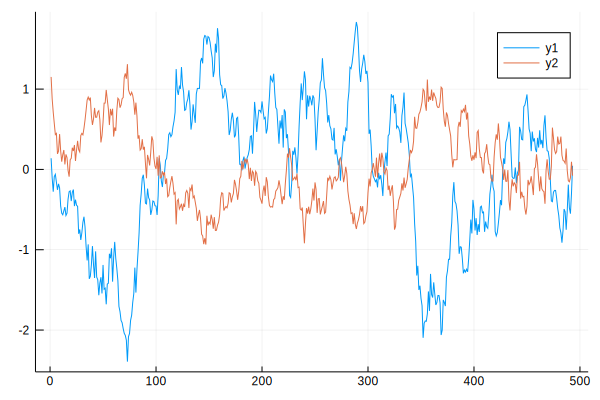

In [162]:
plot(results[results[:,1] .!= 0,:])

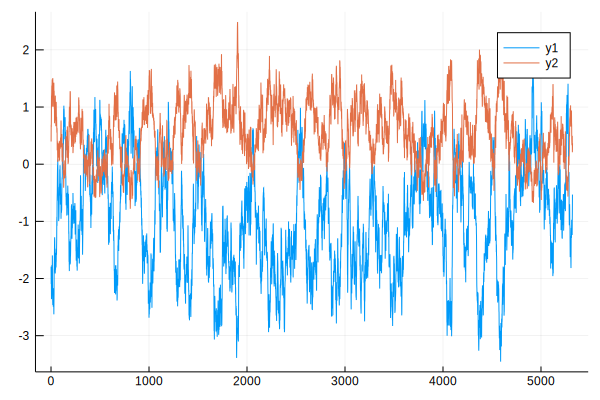

In [149]:
plot(result[result[:,1] .!= 0,:])

In [152]:
mean(result[result[:,1] .!= 0,:],dims=1)

1×2 Array{Float64,2}:
 -0.990787  0.553526

In [465]:
y=x.copy()
y[1,1]=3456
y

ErrorException: type Array has no field copy

In [72]:
teste1

4×4 Array{Int64,2}:
 0  1  1  0
 1  0  1  0
 1  1  0  1
 0  0  1  0